In [1]:
import os
import datetime
import glob
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import requests
from pymongo import MongoClient

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

mongo_name = ['Australia', 'Bahrain', 'Brazil', 'Brunei', 'Cambodia','Canada', 'Hong Kong',
                'China', 'Czech', 'Denmark', 'Euro', 'Fiji', 'Hungary', 'India', 'Indonesia', 'Israel',
                'Japan', 'Jordan', 'Kuwait', 'Malaysia', 'Mexico', 'New Zealand',
                'Norway', 'Philippines', 'Poland', 'Russia', 'Saudi Arabia', 'Singapore', 'South Africa',
                'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'UAE', 'UK', 'USA', 'Vietnam']

In [131]:
mongo_name = ['Australia', 'Bahrain', 'Brazil', 'Brunei',
              'Cambodia','Canada', 'Hong Kong',
                'China', 'Czech', 'Denmark', 'Euro',
                'Fiji', 'Hungary', 'India', 'Indonesia',
                'Israel',
                'Japan', 'Jordan', 'Kuwait', 'Malaysia',
                'Mexico', 'New Zealand',
                'Norway', 'Philippines', 'Poland', 'Russia',
                'Saudi Arabia', 'Singapore', 'South Africa',
                'Sweden', 'Switzerland', 'Taiwan', 'Thailand',
                'Turkey', 'UAE', 'UK', 'USA', 'Vietnam']

class preprocess():
    def __init__(self):
        self.client = MongoClient('localhost', 27017)
        self.db_ex = self.client['exchange']
        self.db_int = self.client['interest']
        self.db_inf = self.client['inflation']
        self.db_m1 = self.client['liquidity']
        
    def monthly_preprocessing(self, country):
        ex_ca = pd.DataFrame(list(self.db_ex[country].find({}, {'_id':0})))
        ex_ca['date'] = pd.to_datetime(ex_ca['date'])
        ex_ca = ex_ca.set_index('date')
        ex_ca['ex'] = np.log(ex_ca['buy'])
        ex_ca = ex_ca.resample(rule = 'M').last()
        
        df = ex_ca.reset_index()[['date','ex']]
        coll_int = self.db_int[country]
        inter = pd.DataFrame(list(coll_int.find({}, {'_id':0})))
        if '1' in inter.columns[1]:
            int_ko = pd.DataFrame(list(self.db_int['Korea1Y'].find({}, {'_id':0})))
            interest = pd.merge(inter, int_ko, on='date', how='inner')
            interest['int_spread'] = interest['interest1Y_y'] - interest['interest1Y_x'] 
            interest['date'] = pd.to_datetime(interest['date'])
            interest = interest[['date', 'int_spread']]

            df = pd.merge(df, interest, on='date', how = 'inner')
            df['date'] = df['date'].dt.strftime("%Y-%m")
        elif '2' in inter.colunns[1]:
            int_ko = pd.DataFrame(list(self.db_int['Korea2Y'].find({}, {'_id':0})))
            interest = pd.merge(inter, int_ko, on='date', how='inner')
            interest['int_spread'] = interest['interest1Y_y'] - interest['interest1Y_x'] 
            interest['date'] = pd.to_datetime(interest['date'])
            interest = interest[['date', 'int_spread']]

            df = pd.merge(df, interest, on='date', how = 'inner')
            df['date'] = df['date'].dt.strftime("%Y-%m")
        elif len(inter) == 0:
            pass

        inf = pd.DataFrame(list(self.db_inf[country + 'M'].find({}, {'_id':0})))
        infq = pd.DataFrame(list(self.db_inf[country + 'Q'].find({}, {'_id':0})))
        inflation_KOR = pd.DataFrame(list(self.db_inf['Korea' + 'M'].find({}, {'_id':0})))
        if len(inf) != 0:
            inf['inf_c'] = inf['inflation'].astype('float').pct_change()*100
            inflation_KOR['inf_kc'] = inflation_KOR['inflation'].astype('float').pct_change()*100
            inflation = pd.merge(inf, inflation_KOR[['date', 'inf_kc']], on='date', how='inner' )
            inflation['inf_spread'] = inflation['inf_kc'] - inflation['inf_c']
            df = pd.merge(df, inflation[['date', 'inf_spread']], on='date', how = 'inner')
        elif len(inf) == 0 and len(infq) != 0:
            infq['date'] = pd.to_datetime(infq['date']).dt.to_period('Q')
            infq = infq.set_index('date').astype('float')
            infq = infq.resample(rule = 'M').fillna(method= 'ffill')
            infq = infq.reset_index()
            infq['date'] = infq['date'].astype('str')
            infq['inf_c'] = infq['inflation'].astype('float').pct_change()*100
            inflation_KOR['inf_kc'] = inflation_KOR['inflation'].astype('float').pct_change()*100
            inflation = pd.merge(infq, inflation_KOR[['date', 'inf_kc']], on='date', how='inner' )
            inflation['inf_spread'] = inflation['inf_kc'] - inflation['inf_c']
            df = pd.merge(df, inflation[['date', 'inf_spread']], on='date', how = 'inner')
        elif len(inf) == 0 and len(infq) == 0:
            pass

        
        m1 = pd.DataFrame(list(self.db_m1[country + 'M'].find({}, {'_id':0})))
        m1q = pd.DataFrame(list(self.db_m1[country + 'Q'].find({}, {'_id':0})))
        if len(m1) != 0:
            m1_KOR = pd.DataFrame(list(self.db_m1['Korea' + 'M'].find({}, {'_id':0})))
            m1['m1'] = np.log(m1['liquidity'].astype('float'))
            m1_KOR['m1_k'] = np.log(m1_KOR['liquidity'].astype('float'))
            m1 = pd.merge(m1[['date','m1']], m1_KOR[['date', 'm1_k']], on='date', how='inner')
            m1['m1_spread'] = m1['m1_k'] - m1['m1']
            df = pd.merge(df, m1[['date', 'm1_spread']], on='date', how = 'inner')
        elif len(m1) == 0 and len(m1q) != 0:
            m1_KOR = pd.DataFrame(list(self.db_m1['Korea' + 'M'].find({}, {'_id':0})))
            m1q['date'] = pd.to_datetime(m1q['date']).dt.to_period('Q')
            m1q = m1q.set_index('date').astype('float')
            m1q = m1q.resample(rule = 'M').fillna(method= 'ffill')
            m1q = m1q.reset_index()
            m1q['date'] = m1q['date'].astype('str')
            m1q['m1'] = np.log(m1q['liquidity'].astype('float'))
            m1_KOR['m1_k'] = np.log(m1_KOR['liquidity'].astype('float'))
            m1q = pd.merge(m1q[['date','m1']], m1_KOR[['date', 'm1_k']], on='date', how='inner')
            m1q['m1_spread'] = m1q['m1_k'] - m1q['m1']
            df = pd.merge(df, m1q[['date', 'm1_spread']], on='date', how = 'inner')
        elif len(m1) == 0 and len(m1q) == 0:
            pass
        
        date_time = pd.to_datetime(df.pop('date'), format='%Y-%m')
        df = df.astype('float')
        
        return df, date_time
    
    def daily_preprocessing(self, country):
        ex_ca = pd.DataFrame(list(self.db_ex[country].find({}, {'_id':0})))
        ex_ca['date'] = pd.to_datetime(ex_ca['date'])
        ex_ca['ex'] = np.log(ex_ca['buy'])
        df = ex_ca[['date','ex']]
        
        coll_int = self.db_int[country]
        inter = pd.DataFrame(list(coll_int.find({}, {'_id':0})))
        if '1' in inter.columns[1]:
            int_ko = pd.DataFrame(list(self.db_int['Korea1Y'].find({}, {'_id':0})))
        elif '2' in inter.colunns[1]:
            int_ko = pd.DataFrame(list(self.db_int['Korea2Y'].find({}, {'_id':0})))

        interest = pd.merge(inter, int_ko, on='date', how='inner')
        interest['int_spread'] = interest['interest1Y_y'] - interest['interest1Y_x']
        interest['date'] = pd.to_datetime(interest['date'])
        interest = interest[['date', 'int_spread']]


        df = pd.merge(df, interest, on='date', how = 'inner')
        
        inf = pd.DataFrame(list(self.db_inf[country + 'M'].find({}, {'_id':0})))
        infq = pd.DataFrame(list(self.db_inf[country + 'Q'].find({}, {'_id':0})))
        inflation_KOR = pd.DataFrame(list(self.db_inf['Korea' + 'M'].find({}, {'_id':0})))
        
        if len(inf) != 0:
            inf['inf_c'] = inf['inflation'].astype('float').pct_change()*100
            inflation_KOR['inf_kc'] = inflation_KOR['inflation'].astype('float').pct_change()*100
            inflation = pd.merge(inf, inflation_KOR[['date', 'inf_kc']], on='date', how='inner' )
            inflation['inf_spread'] = inflation['inf_kc'] - inflation['inf_c']
            inflation['date'] = pd.to_datetime(inflation['date']).dt.to_period('M')
            inflation = inflation.set_index('date')
            inflation = inflation.resample(rule = 'D').fillna(method= 'ffill')
            inflation = inflation.reset_index()
            inflation['date'] = pd.to_datetime(inflation['date'].astype('str'))
            df = pd.merge(df, inflation[['date', 'inf_spread']], on='date', how = 'inner')
        elif len(inf) == 0 and len(infq) != 0:
            infq['date'] = pd.to_datetime(infq['date']).dt.to_period('Q')
            infq = infq.set_index('date').astype('float')
            infq = infq.resample(rule = 'M').fillna(method= 'ffill')
            infq = infq.reset_index()
            infq['date'] = infq['date'].astype('str')
            infq['inf_c'] = infq['inflation'].astype('float').pct_change()*100
            inflation_KOR['inf_kc'] = inflation_KOR['inflation'].astype('float').pct_change()*100
            inflation = pd.merge(infq, inflation_KOR[['date', 'inf_kc']], on='date', how='inner' )
            inflation['inf_spread'] = inflation['inf_kc'] - inflation['inf_c']
            inflation['date'] = pd.to_datetime(inflation['date']).dt.to_period('M')
            inflation = inflation.set_index('date')
            inflation = inflation.resample(rule = 'D').fillna(method= 'ffill')
            inflation = inflation.reset_index()
            inflation['date'] = pd.to_datetime(inflation['date'].astype('str'))
            df = pd.merge(df, inflation[['date', 'inf_spread']], on='date', how = 'inner')
        elif len(inf) == 0 and len(infq) == 0:
            pass
        
        m1 = pd.DataFrame(list(self.db_m1[country + 'M'].find({}, {'_id':0})))
        m1q = pd.DataFrame(list(self.db_m1[country + 'Q'].find({}, {'_id':0})))
        if len(m1) != 0:
            m1_KOR = pd.DataFrame(list(self.db_m1['Korea' + 'M'].find({}, {'_id':0})))
            m1['m1'] = np.log(m1['liquidity'].astype('float'))
            m1_KOR['m1_k'] = np.log(m1_KOR['liquidity'].astype('float'))
            m1 = pd.merge(m1[['date','m1']], m1_KOR[['date', 'm1_k']], on='date', how='inner')
            m1['m1_spread'] = m1['m1_k'] - m1['m1']
            m1['date'] = pd.to_datetime(m1['date']).dt.to_period('M')
            m1 = m1.set_index('date')
            m1 = m1.resample(rule = 'D').fillna(method= 'ffill')
            m1 = m1.reset_index()
            m1['date'] = pd.to_datetime(m1['date'].astype('str'))
            df = pd.merge(df, m1[['date', 'm1_spread']], on='date', how = 'inner')
        elif len(m1) == 0 and len(m1q) != 0:
            m1_KOR = pd.DataFrame(list(self.db_m1['Korea' + 'M'].find({}, {'_id':0})))
            m1q['date'] = pd.to_datetime(m1q['date']).dt.to_period('Q')
            m1q = m1q.set_index('date').astype('float')
            m1q = m1q.resample(rule = 'M').fillna(method= 'ffill')
            m1q = m1q.reset_index()
            m1q['date'] = m1q['date'].astype('str')
            m1q['m1'] = np.log(m1q['liquidity'].astype('float'))
            m1_KOR['m1_k'] = np.log(m1_KOR['liquidity'].astype('float'))
            m1q = pd.merge(m1q[['date','m1']], m1_KOR[['date', 'm1_k']], on='date', how='inner')
            m1q['m1_spread'] = m1q['m1_k'] - m1q['m1']
            m1q['date'] = pd.to_datetime(m1q['date']).dt.to_period('M')
            m1q = m1q.set_index('date')
            m1q = m1q.resample(rule = 'D').fillna(method= 'ffill')
            m1q = m1q.reset_index()
            m1q['date'] = pd.to_datetime(m1q['date'].astype('str'))
            df = pd.merge(df, m1q[['date', 'm1_spread']], on='date', how = 'inner')
        elif len(m1) == 0 and len(m1q) == 0:
            pass
        
        date_time = pd.to_datetime(df.pop('date'), format='%Y-%m-%d')
        df = df.astype('float')
        
        return df, date_time

In [146]:
pre = preprocess()
df, date_time = pre.monthly_preprocessing('Japan')
date_time

0     2006-07-01
1     2006-08-01
2     2006-09-01
3     2006-10-01
4     2006-11-01
         ...    
185   2021-12-01
186   2022-01-01
187   2022-02-01
188   2022-03-01
189   2022-04-01
Name: date, Length: 190, dtype: datetime64[ns]

In [147]:
df.isnull().sum()

ex            0
int_spread    0
inf_spread    0
m1_spread     0
dtype: int64

In [148]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ex,190.0,7.007005,0.172223,6.635802,6.914398,6.975338,7.143918,7.380349
int_spread,190.0,2.475684,1.094333,0.713000,1.682250,2.315000,3.201500,5.107000
inf_spread,190.0,0.148672,0.398013,-2.025076,-0.089091,0.163315,0.393532,1.294345
m1_spread,190.0,-1.256086,0.111771,-1.613053,-1.325326,-1.249832,-1.175386,-1.052326


In [149]:
n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
num_features

4

In [194]:
df = df[:30]

In [195]:
len(df)

30

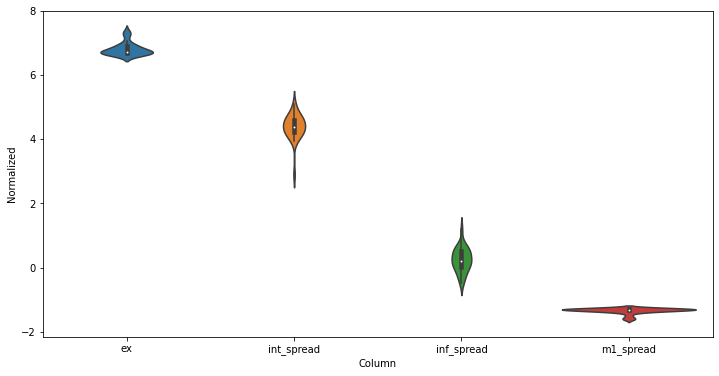

In [196]:
column_indices = {name: i for i, name in enumerate(df.columns)}


train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys())

In [215]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] 
                 for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='ex'):
        print('example:',self.example)
        print('다음')
        inputs, labels = self.example
        print('inputs:',inputs)
        print('다음')
        print('labels:',labels)
        print('다음')
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        print('column_indices:',self.column_indices)
        print(plot_col_index)
        plt.ylabel(f'{plot_col} [normed]')
        print('다음')
        print('input_indices:',self.input_indices)
        plt.plot(self.input_indices, inputs[5, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index


        plt.scatter(self.label_indices, labels[5, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[5, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

        plt.legend()

        plt.xlabel('Time [h]')
        
#         inputs, labels = self.example
#         plt.figure(figsize=(12, 8))
#         plot_col_index = self.column_indices[plot_col]
#         max_n = min(max_subplots, len(inputs))
#         for n in range(max_n):
#             plt.subplot(max_n, 1, n+1)
#             plt.ylabel(f'{plot_col} [normed]')
#             plt.plot(self.input_indices, inputs[n, :, plot_col_index],
#                  label='Inputs', marker='.', zorder=-10)

#             if self.label_columns:
#                 label_col_index = self.label_columns_indices.get(plot_col, None)
#             else:
#                 label_col_index = plot_col_index

#             if label_col_index is None:
#                 continue

#             plt.scatter(self.label_indices, labels[n, :, label_col_index],
#                         edgecolors='k', label='Labels', c='#2ca02c', s=64)
#             if model is not None:
#                 predictions = model(inputs)
#                 plt.scatter(self.label_indices, predictions[n, :, label_col_index],
#                           marker='X', edgecolors='k', label='Predictions',
#                           c='#ff7f0e', s=64)

#             if n == 0:
#                 plt.legend()

#         plt.xlabel('Time [h]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=False,
          batch_size=6,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
            
        return result

In [216]:
val_performance = {}
performance = {}
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
#     early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                     patience=patience,
#                                                     mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])


#     history = model.fit(window.train, epochs=MAX_EPOCHS,
#                       validation_data=window.val,
#                       callbacks=[early_stopping], verbose=1)
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      verbose=1)
    return history

example: (<tf.Tensor: shape=(6, 6, 4), dtype=float32, numpy=
array([[[-1.392726  ,  1.3672308 ,  1.3277161 , -0.4626579 ],
        [-1.4829572 ,  1.4907343 , -0.68936765, -0.48611736],
        [-1.6017917 ,  1.4127853 ,  0.341644  , -0.46990424],
        [-1.5963515 ,  1.2457519 , -1.0341667 , -0.46398848],
        [-1.6122402 ,  1.190074  , -0.29324743, -0.3768714 ],
        [-1.7373061 ,  1.261949  ,  0.09768709, -0.16720247]],

       [[-1.4829572 ,  1.4907343 , -0.68936765, -0.48611736],
        [-1.6017917 ,  1.4127853 ,  0.341644  , -0.46990424],
        [-1.5963515 ,  1.2457519 , -1.0341667 , -0.46398848],
        [-1.6122402 ,  1.190074  , -0.29324743, -0.3768714 ],
        [-1.7373061 ,  1.261949  ,  0.09768709, -0.16720247],
        [-1.7741066 ,  1.7670989 ,  0.6043378 , -0.11181451]],

       [[-1.6017917 ,  1.4127853 ,  0.341644  , -0.46990424],
        [-1.5963515 ,  1.2457519 , -1.0341667 , -0.46398848],
        [-1.6122402 ,  1.190074  , -0.29324743, -0.3768714 ],
     

Total window size: 12
Input indices: [0 1 2 3 4 5]
Label indices: [ 6  7  8  9 10 11]
Label column name(s): None

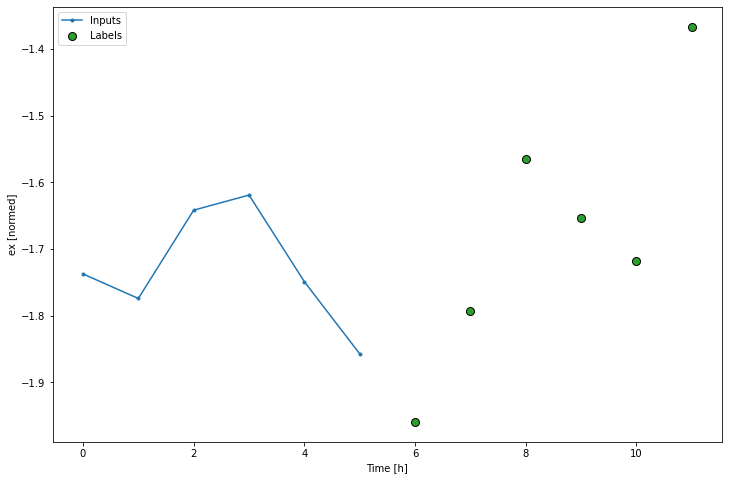

In [217]:
multi_val_performance = {}
multi_performance = {}
OUT_STEPS = 6
multi_window = WindowGenerator(input_width=6,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [225]:
df.to_numpy

<bound method DataFrame.to_numpy of           ex  int_spread  inf_spread  m1_spread
0   6.744295       4.135    0.699619  -1.333757
1   6.727024       4.257   -0.136340  -1.336153
2   6.704280       4.180    0.290952  -1.334497
3   6.705321       4.015   -0.279238  -1.333893
4   6.702280       3.960    0.027828  -1.324998
5   6.678342       4.031    0.189846  -1.303589
6   6.671298       4.530    0.399822  -1.297933
7   6.696664       4.255    1.197077  -1.297788
8   6.701002       4.186    0.269188  -1.297711
9   6.676113       4.366    0.073166  -1.291110
10  6.655402       4.286   -0.212829  -1.272610
11  6.635802       4.408    0.205550  -1.275721
12  6.667631       4.423    0.485843  -1.270184
13  6.711278       4.598   -0.420755  -1.277448
14  6.694352       4.604    0.571553  -1.282370
15  6.682184       4.599   -0.119529  -1.279681
16  6.749369       4.819    0.204499  -1.289632
17  6.741335       5.107    0.173240  -1.290471
18  6.805435       4.687    0.673520  -1.313151
19  

2/2 [==============================] - 0s 9ms/step - loss: 0.4443 - mean_absolute_error: 0.5471
example: (<tf.Tensor: shape=(6, 6, 4), dtype=float32, numpy=
array([[[-1.392726  ,  1.3672308 ,  1.3277161 , -0.4626579 ],
        [-1.4829572 ,  1.4907343 , -0.68936765, -0.48611736],
        [-1.6017917 ,  1.4127853 ,  0.341644  , -0.46990424],
        [-1.5963515 ,  1.2457519 , -1.0341667 , -0.46398848],
        [-1.6122402 ,  1.190074  , -0.29324743, -0.3768714 ],
        [-1.7373061 ,  1.261949  ,  0.09768709, -0.16720247]],

       [[-1.4829572 ,  1.4907343 , -0.68936765, -0.48611736],
        [-1.6017917 ,  1.4127853 ,  0.341644  , -0.46990424],
        [-1.5963515 ,  1.2457519 , -1.0341667 , -0.46398848],
        [-1.6122402 ,  1.190074  , -0.29324743, -0.3768714 ],
        [-1.7373061 ,  1.261949  ,  0.09768709, -0.16720247],
        [-1.7741066 ,  1.7670989 ,  0.6043378 , -0.11181451]],

       [[-1.6017917 ,  1.4127853 ,  0.341644  , -0.46990424],
        [-1.5963515 ,  1.2457519 

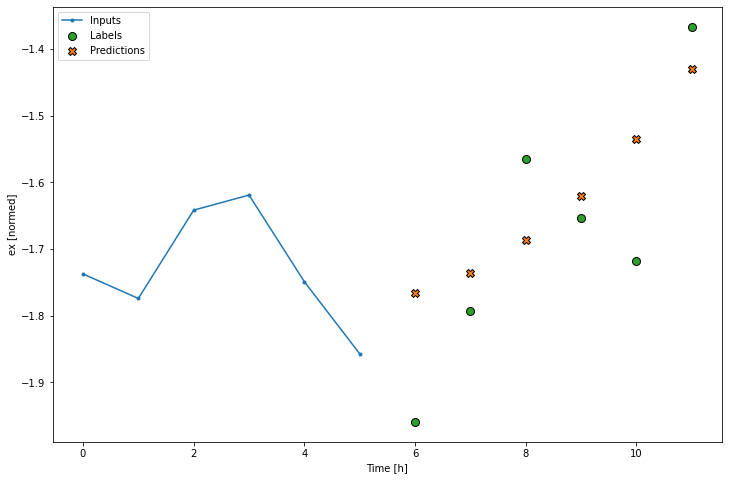

In [218]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(36, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [219]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)

        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)

        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state,
                                  training=training)
            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [220]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([6, 4])

In [221]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (6, 6, 4)


2/2 [==============================] - 0s 16ms/step - loss: 0.4335 - mean_absolute_error: 0.5519
example: (<tf.Tensor: shape=(6, 6, 4), dtype=float32, numpy=
array([[[-1.392726  ,  1.3672308 ,  1.3277161 , -0.4626579 ],
        [-1.4829572 ,  1.4907343 , -0.68936765, -0.48611736],
        [-1.6017917 ,  1.4127853 ,  0.341644  , -0.46990424],
        [-1.5963515 ,  1.2457519 , -1.0341667 , -0.46398848],
        [-1.6122402 ,  1.190074  , -0.29324743, -0.3768714 ],
        [-1.7373061 ,  1.261949  ,  0.09768709, -0.16720247]],

       [[-1.4829572 ,  1.4907343 , -0.68936765, -0.48611736],
        [-1.6017917 ,  1.4127853 ,  0.341644  , -0.46990424],
        [-1.5963515 ,  1.2457519 , -1.0341667 , -0.46398848],
        [-1.6122402 ,  1.190074  , -0.29324743, -0.3768714 ],
        [-1.7373061 ,  1.261949  ,  0.09768709, -0.16720247],
        [-1.7741066 ,  1.7670989 ,  0.6043378 , -0.11181451]],

       [[-1.6017917 ,  1.4127853 ,  0.341644  , -0.46990424],
        [-1.5963515 ,  1.2457519

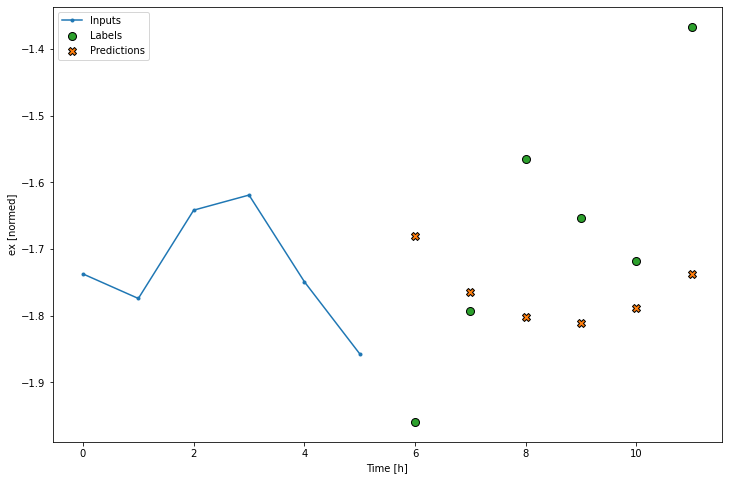

In [222]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

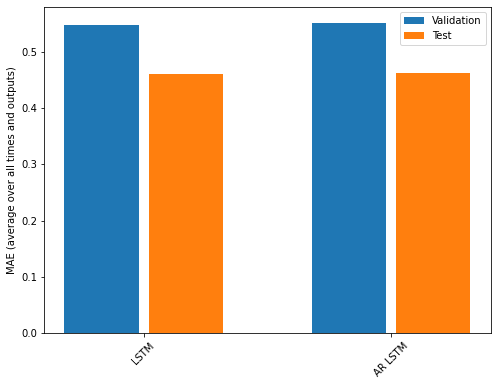

In [223]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [224]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

LSTM    : 0.4595
AR LSTM : 0.4624
